# 通常攻撃SEの共分散のアニメーションイメージ

音声で通常攻撃のどの種類の攻撃がヒットしたかを、音声の共分散を用いて判定することを考えましたが、どうにもイメージがわかないので、アニメーションで可視化させます。

### 準備
通常攻撃の音声を録音し、ファイルとして用意して`./SFV_SE/`フォルダに格納しておきます。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import soundfile as sf
import matplotlib.animation as animation
from scipy import signal

import matplotlib
import warnings

# データ読み込み
folder = './SFV_SE/'
data_w, fs = sf.read(folder + 'whole.wav')

# 標準偏差が1となるよう正規化（共分散を比較するため）
data_w = data_w / np.std(data_w)

'whole.wav'はfs=44.1kHzです。前回の6種の攻撃ごとのファイルではなく、6種の攻撃を各6回ずつヒットさせたときの音声が入っている生のゲーム音声ファイルです。下で、ダウンサンプリングした後にグラフ表示しています。

（ここで音声を聞けるように要素を挿入）

### ダウンサンプリング
データ数が多いと、リアルタイム処理ができない可能性があるのと、いちいち解析に時間がかかるので、1/100にダウンサンプリングして、fsを441Hzにします。

ダウンサンプリングって何？って人は、こちらを。
（記事リンク）

もちろん、あまりダウンサンプリングレート(DSR)を高くしてデータを間引きすぎてしまうと、情報量が足りなくなって、検出精度に影響を及ぼします。

In [2]:
# ダウンサンプリング
# decimate関数ヘルプより：DSRが13を超える場合は複数回に分ける
# 理由はおそらく、ダウンサンプリング用LPFを設計できないため
dsr1 = 10  # 1回あたりのDSR
dsr = dsr1*dsr1  # 2回でDSRは100になる

# ダウンサンプリング用LPFはFIR型とする
# FIR型フィルタは位相特性が直線なので、波形が保存される
data_w = signal.decimate(data_w, dsr, ftype='fir')  # 全く同じことを2回やる
data_w = signal.decimate(data_w, dsr, ftype='fir')
fs = int(fs/dsr)  # サンプリング周波数を更新

ここで、2回に分けてダウンサンプリングしている理由は、`scipy.decimate()`の仕様で、DSRが13を超える場合は、複数回に分けることが推奨されているためです。DSR=10で2回ダウンサンプリングして、DSR=100を実現しています。高いDSRで1回で済まそうとすると、エラーを吐きます（やってみてください）。

ただ実は、これは単に`scipy.decimate()`の実装の問題というより、もっと原理的な、ディジタルフィルタの設計に関する問題です。有名な科学計算ソフトであるMATLABにも同様の関数がありますが、やはりDSRが高いときは、エラーを吐きます。

簡単に理由を説明します。ナイキスト周波数をfs/2とすると、ここで使われる折返し誤差防止用のローパスフィルタ(LPF)の通過帯域幅はfs/2/DSRとなり、fs/2に対して非常に狭いです。この条件でLPFを設計しようとすると、ほとんどLPFというより、実質上は単なる共振フィルタとなってしまい、フィルタの安定性にも精度にも問題が出てきてしまうので、設計がが非常に困難になる、といった感じです。

### 弱P(LP)の音声抜き出し

今回は、図の見た目を重視して、`whole.waav`からLP1発相当のSEを切り出しておきます。

In [3]:
LP = data_w[2894:3038]  # この部分がLPのSE

### プロット
何はともあれ、まずは結果を見てみましょう。散々試行錯誤したのですが、別のコンソールでは動画も作れてアニメーションもするのに、Jupyter Notebookではアニメできませんでした。しかも`plot`命令のところでエラーが出るし・・・。

（コードは隠す）

Traceback (most recent call last):
  File "C:\Users\h29-006\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 388, in process
    proxy(*args, **kwargs)
  File "C:\Users\h29-006\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 228, in __call__
    return mtd(*args, **kwargs)
  File "C:\Users\h29-006\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1026, in _start
    self._init_draw()
  File "C:\Users\h29-006\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "C:\Users\h29-006\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1772, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-5-270a3aefa675>", line 29, in plot
    plt.plot(x, data_w[k:k+len(x)], alpha=0.8)  # 全体音声プロット
  File "C:\Users\h29-006\Anaconda3\lib\site-packages\matplotlib\pyplot.py", line 3358, in plot
    ret = ax.plot(*args, **kwargs)
  File 

ValueError: x and y must have same first dimension, but have shapes (441,) and (0,)

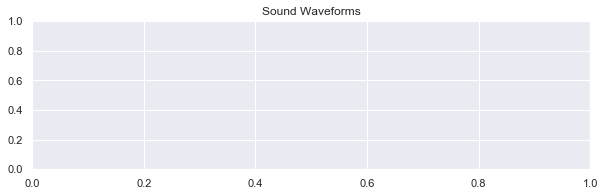

In [5]:
#%% グラフプロット
from IPython.display import HTML
sb.set()
x = np.linspace(-0.5, 0.5, int(fs))  # amp用
xx = x[221-len(LP):221]
k_stop = 2894-(221-len(LP))+1  # data_wの停止時刻

fig, ax = plt.subplots(figsize=(10,6))
i = 0
k = k_stop-400
cv = np.empty(0)

def plot(frame):
    # future warining抑制
    warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

    global k
    global i
    global cv

    i = i + 1
    k = k + 1

    # [1] waveforms
    ax = plt.subplot(2,1,1)
    if k < k_stop:
        plt.cla()  # 図をクリア
        plt.title('Sound Waveforms')
        plt.plot(x, data_w[k:k+len(x)], alpha=0.8)  # 全体音声プロット
        plt.plot(xx, LP, alpha=0.7)  # LP音声プロット
        plt.xlim(-0.5, 0.5)
        plt.ylim(-3, 3)
        plt.tick_params(labelbottom=False)
        plt.legend(['game sound','LP sound'], loc=4)
        plt.fill([xx[0],xx[0],0,0],[-5,3,3,-5], alpha=0.1, color='coral')
        plt.vlines(0, -3, 3, colors='k', linewidth=1, linestyles='dotted', alpha=0.5)
        ax.annotate('waveform of\nLP sound', xy=(-0.185,2), color='coral')
        plt.ylabel('amplitude')
    if k == k_stop:
        ax.annotate('2 waveforms\nare matched! [A]', xy=(-0.17,-2), color='r', fontsize=15)
        plt.vlines(-144/441, -3, 3, colors='k', linewidth=1, linestyles='dotted', alpha=0.5)

    # [2] covariance
    ax = plt.subplot(2,1,2)
    if k < k_stop:
        LP_w = data_w[k+77:k+77+len(LP)]  # LPとのcov計算のためにwholeから切り出す
        temp = np.cov(LP/np.std(LP), LP_w/np.std(LP_w))  # cov計算
        cv = np.append(cv, temp[0,1])  # グラフのためにcov蓄積
        x_cv = np.linspace(-i*(1/fs), 0, i)  # covグラフ軸

        plt.cla()  # 図をクリア
        plt.title('Covariance and Threshold')
        plt.plot(x_cv, cv, color='yellowgreen')  # 過去のcov
        plt.plot(0, cv[-1], 'o', color='yellowgreen') # 現在のcov
        plt.hlines(0.6, -0.5, 0.5, colors='forestgreen', linestyles='dashed', alpha=0.5)
        plt.vlines(0, -1, 1.2, colors='k', linewidth=1, linestyles='dotted', alpha=0.5)
        plt.xlim(-0.5, 0.5)
        plt.ylim(-1, 1.2)
        plt.xlabel('time[s]')
        plt.ylabel('covariance')
        plt.legend(['past covariance','current covariance'], loc=4)

        pos_ty = -0.75
        ax.annotate('NOW', xy=(0,pos_ty-0.15), ha='center', color='gray')
        ax.annotate('', xy=(0,pos_ty), xycoords='data',
                    xytext=(-0.1,pos_ty), textcoords='data', 
                    arrowprops=dict(arrowstyle='<-', color='gray'))
        ax.annotate('past', xy=(-0.1,pos_ty-0.15), ha='center', color='gray')
        ax.annotate('', xy=(0,pos_ty), xycoords='data',
                    xytext=(0.1,pos_ty), textcoords='data', 
                    arrowprops=dict(arrowstyle='<-', color='gray'))
        ax.annotate('future', xy=(0.1,pos_ty-0.15), ha='center', color='gray')
        ax.annotate('threshold', xy=(0.48,0.62), ha='right', color='forestgreen')
    if i > 133:
        ax.annotate('LP detected!', xy=((133-i)/fs,cv[133]), xycoords='data',
                    xytext=((133-i)/fs+0.15,0.8), textcoords='data', color='coral', fontsize=15, ha='center',
                    arrowprops=dict(arrowstyle='->', color='coral'))
    if k == k_stop:
        ax.annotate('covariance is max(1.0)!\n(this means [A])', xy=(0.17, 0.02), color='r', fontsize=15, ha='center')
        ax.annotate('LP detected!', xy=(0,1), xycoords='data',
                    xytext=(0.15,0.8), textcoords='data', color='coral', fontsize=15, ha='center',
                    arrowprops=dict(arrowstyle='->', color='coral'))
        ax.annotate('detection lag', xy=(-72/441,0.82), ha='center', color='coral')
        ax.annotate('', xy=(-144/441,0.8), xycoords='data',
                    xytext=(0,0.8), textcoords='data', color='coral',
                    arrowprops=dict(arrowstyle='<->', color='coral', linestyle='dotted'))
        plt.vlines(-144/441, 0.5, 1.2, colors='k', linewidth=1, linestyles='dotted', alpha=0.5)
    plt.tight_layout()
    return fig,
    
ani = animation.FuncAnimation(fig, plot, interval=50, frames=500, blit=True)
#ani.save("anim.mp4", writer = 'ffmpeg', bitrate=1500)
#plt.show()

HTML(ani.to_html5_video())



時間経過にしたがって青色の`game sound`を動かし、それがオレンジ色の`LP sound`と重なった部分の共分散を計算したものが黄緑色の`covariance`です。現時刻`NOW`での共分散を、黄緑色の上下する丸`corrent covariance`で表しています。共分散が緑色の`threshold`を超えたときには、オレンジ色の領域の`game sound`と`LP sound`の波形がかなり似ているということになるため、このとき「LPがヒットした」と判断しよう、というわけです。

以前に、共分散によるヒット確認について説明しました。

（過去ブログカード表示）

これは、上のアニメーションにおける`LP hit detected`のときの値だけを検証したものです。それ以外のときに、時間経過によって、共分散がどのような値になっているのか、見えてきたのではないでしょうか。


## 課題
苦労してアニメーションを作成したのは、単に楽しいからだけではありません（まぁ、楽しいんですけど）。**ある現象を、適切な可視化を通して、手袋越しではなく素手で掴むため**です。こういった詳細な観察より、課題が見えてきます。

### 検出ラグ（参照SEの長さ）
アニメーションより、ヒットSEが現時刻を通過してから、言い換えれば、ヒットSEが聞こえてから少し経ってから、ヒット検出のための共分散の値が計算されることがわかります。すなわち、検出にはラグがある(アニメ中の`detection lag`)ということです。

このラグは、参照ヒットSEの長さに等しいですから、ラグを短くするには、この長さを短くすればいいことになります。ただ、この長さを短くしすぎると、単なるBGMや他のSEによって計算された共分散もしきい値を超えてしまったりするため、判定精度が落ちます。

この値を適切な長さに決定します。もちろんヒットSEごとに適切な長さは変わります。

### サンプリング周波数(fs)
上の方で言及しましたが、fsについては、DSR=100として決め打ちで実行しました。ただ、fsによっては、リアルタム処理が追いつかなくなる恐れがありますので、検出精度に与える影響が少ない範囲で、なるべくfsを下げたいところです。

まぁ、いずれにせよfs=441Hzというのはだいぶ低いので、これ以上は下げられないような気はします。

### しきい値
しきい値は単なる値ですが、されど共分散がこの値を超えたか否かでヒット検出をするので、非常に重要です。上の検出ラグとfsの問題とも関係していますので、適宜実験して様子を見ながら調整していきます。

一般的にしきい値というのは、応用対象の外的要因に左右されるため、理論的には決定しにくいです。ただそれ故、強力な武器にもなりえます。

（コラム）理論的に決定しにくい値やデータは、実験でしかわかりません。実験には人件費と時間などの膨大なコストがかかることが多く、それだけ価値があるため、秘匿されることが多いです。逆に、学術的な価値があると考えられている理論については、公知の事実となっていれば誰でも同じ結果が得られるため、特に企業では、ほとんど価値がないと考えられることもあります。世の中にとってはどちらも必要ですが、私としては、カネと時間をかければわかるデータより、閃きがない限り思いつかない理論の方に価値があってほしいと願います。

### 他のSEについて
今回はLPについてのみ行いましたが、他の5種についても同様のに検証する必要があります。ただ、大きくは変わらないと思います。


## まとめ
今回は、以前は説明した共分散が、時間経過につれてどのような振る舞いをするかを、アニメーションで示しました。次回は、上で挙げた課題について、検証していきます。